Library import

In [1]:
import os   #untuk mengimport modul agar python berinteraksi dengan os
import torch    #library untuk tensor deep learning
import torchvision  #bagian dari Torch untuk image / vide classification
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

Input Directory

In [3]:
data_dir  = 'D:/Programming/VScode/Python/Trash_Sorter/Garbage classification/Garbage classification'   #lokasi data pelatihan / validasi / testing

classes = os.listdir(data_dir) #agar python dapat berinteraksi dengan directory
print(classes)  #menampilkan kelas(folder) yang disediakan dalam directory (untuk cek)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


Applying Transformation

In [4]:
from torchvision.datasets import ImageFolder    #untuk load image dari folder
import torchvision.transforms as transforms     #untuk mengubah image

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])    #standarisasi ukuran img dan diubah ke Tensor

dataset = ImageFolder(data_dir, transform = transformations)    #standarisasi yang disimpan di dataset 

img & label printer

In [5]:
import matplotlib.pyplot as plt     #untuk menampilkan plot (plot x & y axis)
%matplotlib inline  
#untuk  membuat plot ditampilkan ke dalam shell yg dijjalankan bukan window terpisah

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")    #menaruh label(kelas/asal folder)
    plt.imshow(img.permute(1, 2, 0))    #menamplkan plot dengan image dalamnya

Label: cardboard (Class No: 0)


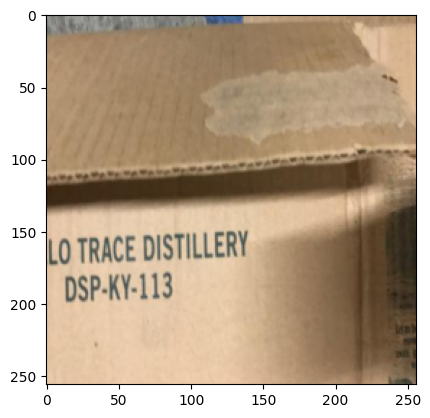

In [6]:
img, label = dataset[12]    
show_sample(img, label)     #untuk menampilkan contoh isi dari dataset

Data Loader & Splitter

Label: cardboard (Class No: 0)


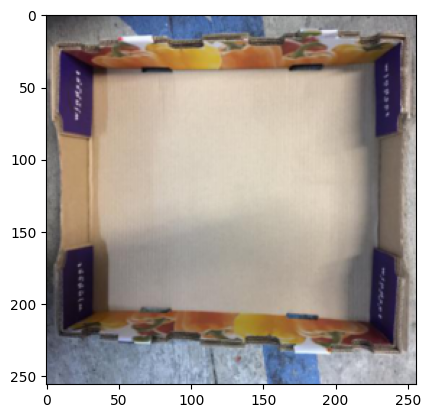

In [9]:
img, label = dataset[22]
show_sample(img, label)     #untuk menampilkan contoh isi dari dataset

In [8]:
train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])     #untuk bagi & simpan isi dataset (1593 utk train, 176 utk validasi, 758 utk test)
len(train_ds), len(val_ds), len(test_ds)    #length masing-masing hasil pembagian

(1593, 176, 758)

In [10]:
from torch.utils.data.dataloader import DataLoader #untuk impor, export dan delete massal data
batch_size = 32

In [11]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True) #impor utk training
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)   #impor utk validasi

Visualizer

In [12]:
from torchvision.utils import make_grid     #sesuai nama utk bikin grid

def show_batch(dl):         #singkatnya ngatur mendisplay batch
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

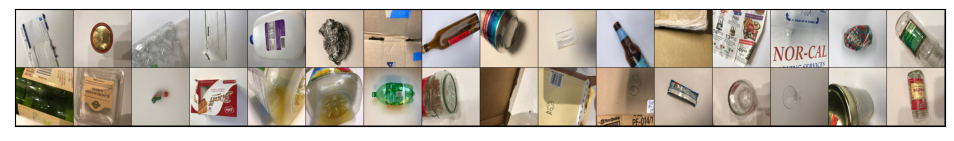

In [13]:
show_batch(train_dl)#contoh batch

Model Base

In [14]:
def accuracy(outputs, labels):      
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):   #class CBB, mengambil data dari fungsi kelas agar dapat menjalankan fungsi dalam kelas
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # membuat prediksi
        loss = F.cross_entropy(out, labels) # kalkulasi loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # membuat prediksi
        loss = F.cross_entropy(out, labels)   # kalkulasi loss
        acc = accuracy(out, labels)           # kalkulasi accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs] # loses batch
        epoch_loss = torch.stack(batch_losses).mean()   # menggabungkan losses
        batch_accs = [x['val_acc'] for x in outputs]    # akurasi batch
        epoch_acc = torch.stack(batch_accs).mean()      # menggabungkan Akurasi-akurasi
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

Image Classification using ResNet50 #ResNet dgn 50 layer

In [15]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Menggunakan pretrained model
        self.network = models.resnet50(pretrained=True)
        # Mengganti layer terakhir
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes)) #buat single layer feed foward network
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))  #prediksi probabilities

model = ResNet()    #model = hasil klasifikasi pakai ResNet

c:\Users\felix\anaconda3\envs\AI-D\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\felix\anaconda3\envs\AI-D\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\felix/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%


GPU Porting

In [16]:
def get_default_device():
     #kalau gk ada gpu pake integrated / cpu
    if torch.cuda.is_available():   #cek apa ada support CUDA, klo gk pake cpu
        return torch.device('cuda') 
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    #pindah tensor ke device yg dipilih 
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #wrap data loader utk mindahin data ke device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        #hasilkan batch data setelah dipindahkan ke device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        #jumlah batch
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cpu')

In [18]:
train_dl = DeviceDataLoader(train_dl, device)  
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)    

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

Model Fitting

In [19]:
@torch.no_grad()    #loop dimana semua tensor dalam loop akan punya requires_grad = false
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]    #model telah dimasukan dalam eval mode & PyTorch gradients telah dinonaktifkan
    return model.validation_epoch_end(outputs)  #return 

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Fase Pelatihan
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Fase Validasi
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
model = to_device(ResNet(), device) 

In [21]:
evaluate(model, val_dl)

{'val_loss': 1.7907603979110718, 'val_acc': 0.1822916716337204}

Model Training

In [22]:
num_epochs = 8  #jumlah brp kali epoch (8 sekitar 1 jam processing)
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)  

Epoch 1: train_loss: 1.4824, val_loss: 1.2443, val_acc: 0.8507
Epoch 2: train_loss: 1.1764, val_loss: 1.1682, val_acc: 0.9149
Epoch 3: train_loss: 1.0998, val_loss: 1.1292, val_acc: 0.9358
Epoch 4: train_loss: 1.0744, val_loss: 1.1218, val_acc: 0.9306
Epoch 5: train_loss: 1.0644, val_loss: 1.1138, val_acc: 0.9497
Epoch 6: train_loss: 1.0568, val_loss: 1.1157, val_acc: 0.9514
Epoch 7: train_loss: 1.0522, val_loss: 1.1153, val_acc: 0.9306
Epoch 8: train_loss: 1.0520, val_loss: 1.1148, val_acc: 0.9444


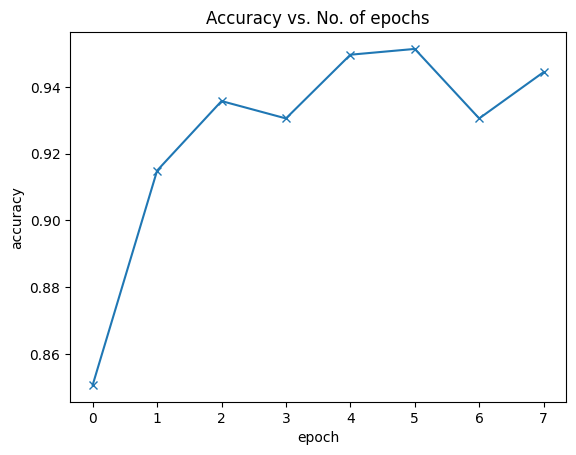

In [23]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

plot_accuracies(history)

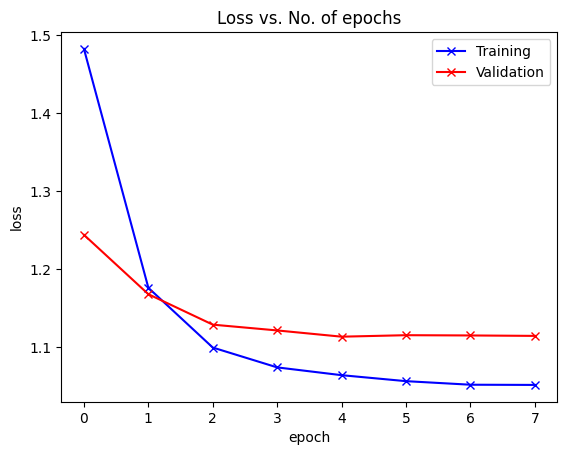

In [24]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

plot_losses(history)

Prediction Visualizer

In [25]:
def predict_image(img, model):
    # konversi ke batch 1
    xb = to_device(img.unsqueeze(0), device)
    # dapatkan prediksi dari model
    yb = model(xb)
    # memilih index dengan probabilitas paling tinggi
    prob, preds  = torch.max(yb, dim=1)
    # ambil label kelas
    return dataset.classes[preds[0].item()]

Label: plastic , Predicted: plastic


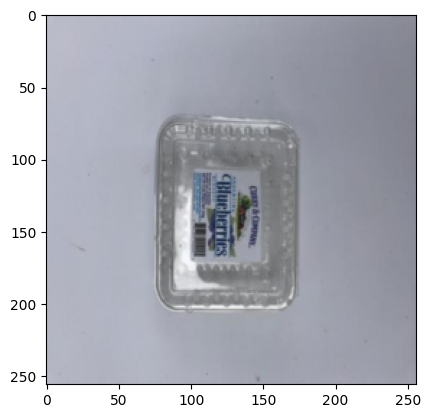

In [26]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))    
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: glass , Predicted: glass


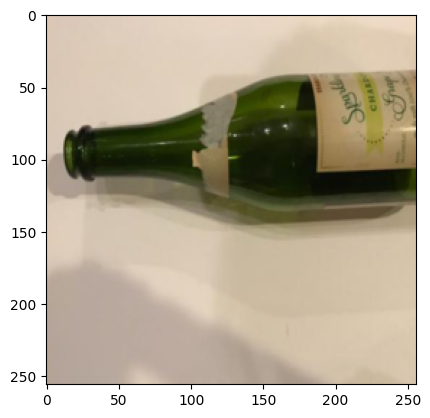

In [27]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: plastic , Predicted: plastic


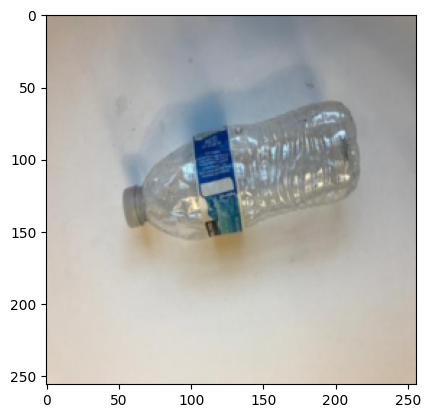

In [28]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [1]:
from flask import Flask, request, send_file
import PIL

app = Flask(__name__)

@app.route("/process-image", methods=["POST"])
def process_image():
    # Get the image file from the request
    image = request.files["image"]
    image = PIL.Image.open(image)
    
    # Process the image (for example, applying a filter)
    image = image.filter(PIL.ImageFilter.BLUR)

    # Save the processed image to a temporary file
    processed_image = "processed_image.jpg"
    image.save(processed_image)

    # Return the processed image as a response
    return send_file(processed_image, mimetype="image/jpeg")

if __name__ == "__main__":
    app.run(debug=True, port=8000)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:8000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

c:\Users\felix\anaconda3\envs\AI-D\lib\site-packages\IPython\core\interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
